<h1 align="center"> 09 — Advanced Model Comparison & Final Model Selection </h1>

This notebook compares multiple model families under identical conditions to select the final production candidate.
- Same processed dataset and *reduced-safe* feature set as in Day 5–6
- Same chronological train/test split
- Strict leakage prevention (only past-looking lags/rolls and simple calendar features)

## 1) Data and Feature Setup (Reproducible and Leakage-safe)

We load `pharma_sales_features_v2_clean.csv`, rebuild the reduced-safe feature set (lags, rolling stats, and basic calendar features only), and reproduce the exact train/test split:
- **Train:** 2014-06-15 → 2018-09-16  
- **Test:**  2018-09-23 → 2019-10-13

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Paths
DATA_DIR = Path("../data/processed")
FILE_PATH = DATA_DIR / "pharma_sales_features_v2_clean.csv"

# 1) Load processed dataset
df = pd.read_csv(FILE_PATH, parse_dates=["datum"], index_col="datum")

print("Full dataset shape:", df.shape)
print("Date range:", df.index.min(), "→", df.index.max())

# 2) Targets
targets = ["N02BE", "M01AB"]

# 3) Build reduced-safe feature set (past-looking only)
#    - include: lag features, rolling features, simple calendar features
#    - exclude: targets themselves and any unknown/leaky columns
calendar_keep = ["weekofyear", "month", "quarter", "year"]

all_cols = df.columns.tolist()
feature_cols = [c for c in all_cols if c not in targets]


def is_reduced_safe(col: str) -> bool:
    # Keep lag/roll features and selected calendar fields
    if ("lag" in col) or ("roll" in col) or (col in calendar_keep):
        return True
    return False


reduced_safe_features = [
    c for c in feature_cols if is_reduced_safe(c) and c in df.columns
]

# 4) Reproduce the same chronological split used in Day 5–6
train = df.loc["2014-06-15":"2018-09-16"].copy()
test = df.loc["2018-09-23":"2019-10-13"].copy()

X_train = train[reduced_safe_features].copy()
X_test = test[reduced_safe_features].copy()
y_train = train[targets].copy()
y_test = test[targets].copy()

# 5) Basic validations
assert len(X_train) > 0 and len(X_test) > 0, "Empty train/test after slicing."
assert (
    X_train.index.is_monotonic_increasing and X_test.index.is_monotonic_increasing
), "Index must be chronological."
assert X_train.index.max() < X_test.index.min(), "Train must end before test starts."

na_train = X_train.isna().sum().sum()
na_test = X_test.isna().sum().sum()

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train end date:", train.index.max())
print("Test start date:", test.index.min())
print(f"Reduced-safe feature count: {len(reduced_safe_features)}")
print(f"Missing values -> X_train: {na_train}, X_test: {na_test}")

# Peek a few columns to visually confirm they are lags/rolls/calendar only
print("\nSample features:", reduced_safe_features[:10])

Full dataset shape: (279, 110)
Date range: 2014-06-15 00:00:00 → 2019-10-13 00:00:00

Train shape: (223, 100)
Test shape: (56, 100)
Train end date: 2018-09-16 00:00:00
Test start date: 2018-09-23 00:00:00
Reduced-safe feature count: 100
Missing values -> X_train: 0, X_test: 0

Sample features: ['M01AB_lag1', 'M01AB_lag2', 'M01AB_lag3', 'M01AB_lag4', 'M01AB_lag8', 'M01AB_lag12', 'M01AE_lag1', 'M01AE_lag2', 'M01AE_lag3', 'M01AE_lag4']


## 2) Model Comparison Setup

To ensure a fair and reproducible comparison:
- We use the same **TimeSeriesSplit** CV strategy for all models (5 folds).
- We define consistent evaluation metrics (RMSE, MAE, MAPE, sMAPE, WAPE).
- We create a **model zoo** including Random Forest (baseline), Gradient Boosting, and optionally XGBoost/LightGBM (if available in the environment).

This setup guarantees that all models are evaluated on identical data and feature sets.

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np

# --- Optional imports (might not be installed)
xgb_available = False
lgbm_available = False
try:
    from xgboost import XGBRegressor

    xgb_available = True
except Exception:
    pass

try:
    from lightgbm import LGBMRegressor

    lgbm_available = True
except Exception:
    pass


# --- Metric functions
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom))) * 100.0


def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum((np.abs(y_true) + np.abs(y_pred)) / 2.0, eps)
    return float(np.mean(np.abs(y_true - y_pred) / denom)) * 100.0


def wape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return (
        np.sum(np.abs(y_true - y_pred)) / np.maximum(np.sum(np.abs(y_true)), eps)
    ) * 100.0


# --- Custom scorer for sklearn CV
rmse_scorer = make_scorer(lambda yt, yp: rmse(yt, yp), greater_is_better=False)

# --- CV setup
tscv = TimeSeriesSplit(n_splits=5)

# --- Random Forest parameters (from Day 5 best-tuned models)
rf_params_by_target = {
    "N02BE": {
        "n_estimators": 200,
        "max_depth": 12,
        "min_samples_split": 5,
        "min_samples_leaf": 4,
        "max_features": "sqrt",
        "bootstrap": True,
        "random_state": 42,
        "n_jobs": -1,
    },
    "M01AB": {
        "n_estimators": 200,
        "max_depth": 16,
        "min_samples_split": 5,
        "min_samples_leaf": 1,
        "max_features": 0.7,
        "bootstrap": True,
        "random_state": 42,
        "n_jobs": -1,
    },
}


# --- Model zoo function
def get_model_zoo(target_name):
    models = {}

    models["RandomForest"] = RandomForestRegressor(**rf_params_by_target[target_name])
    models["GradientBoosting"] = GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9,
        random_state=42,
    )

    if xgb_available:
        models["XGBoost"] = XGBRegressor(
            n_estimators=700,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
        )

    if lgbm_available:
        models["LightGBM"] = LGBMRegressor(
            n_estimators=700,
            learning_rate=0.05,
            num_leaves=31,
            max_depth=-1,
            feature_fraction=0.9,
            bagging_fraction=0.9,
            bagging_freq=1,
            reg_lambda=0.0,
            random_state=42,
            n_jobs=-1,
        )
    return models


# --- Quick validation
print("Targets:", targets)
print("Reduced-safe features:", len(reduced_safe_features))
print("CV splits:", tscv.get_n_splits())
print("XGBoost available? ->", xgb_available)
print("LightGBM available? ->", lgbm_available)

for t in targets:
    print(f"[{t}] models to compare:", list(get_model_zoo(t).keys()))

Targets: ['N02BE', 'M01AB']
Reduced-safe features: 100
CV splits: 5
XGBoost available? -> True
LightGBM available? -> True
[N02BE] models to compare: ['RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']
[M01AB] models to compare: ['RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']


## 3) Cross-Validation Evaluation (RMSE, MAE, sMAPE)

In this step, we evaluate all models under the same data and CV settings.
Each model is scored based on:
- **RMSE (Root Mean Squared Error)** → penalizes large errors  
- **MAE (Mean Absolute Error)** → average deviation in original units  
- **sMAPE (Symmetric Mean Absolute Percentage Error)** → scale-independent accuracy

We then compile the results into a single summary table to identify the best-performing model per target.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict

# --- Cross-validation evaluation loop
cv_results = []

for target in targets:
    y = y_train[target].values
    X = X_train[reduced_safe_features].values

    print(f"\nEvaluating models for target: {target}")
    model_zoo = get_model_zoo(target)

    for model_name, model in model_zoo.items():
        preds = cross_val_predict(model, X, y, cv=tscv)
        rmse_val = rmse(y, preds)
        mae_val = mean_absolute_error(y, preds)
        smape_val = smape(y, preds)
        cv_results.append(
            {
                "Target": target,
                "Model": model_name,
                "RMSE": rmse_val,
                "MAE": mae_val,
                "sMAPE (%)": smape_val,
            }
        )
        print(
            f"{model_name:<15} | RMSE={rmse_val:.3f}, MAE={mae_val:.3f}, sMAPE={smape_val:.2f}%"
        )

# --- Compile into DataFrame
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.sort_values(["Target", "RMSE"], inplace=True)
display(cv_results_df)

# --- Optional: Save results
cv_results_df.to_csv("../results/model_cv_comparison.csv", index=False)


Evaluating models for target: N02BE


ValueError: cross_val_predict only works for partitions

We cannot use `cross_val_predict` with expanding-window `TimeSeriesSplit` because not every sample appears exactly once in a test fold.  
Instead, we run a manual CV loop: for each split, fit on the train part, predict on the validation part, compute metrics, and average across folds.


In [4]:
import pandas as pd
import numpy as np
from statistics import mean, stdev


def evaluate_model_cv(model, X, y, cv):
    """Run manual TimeSeriesSplit CV and return mean/std of RMSE, MAE, sMAPE."""
    rmse_list, mae_list, smape_list = [], [], []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X), start=1):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_va)

        rmse_list.append(rmse(y_va, y_hat))
        mae_list.append(mean_absolute_error(y_va, y_hat))
        smape_list.append(smape(y_va, y_hat))

    def agg(vals):
        return float(mean(vals)), float(stdev(vals)) if len(vals) > 1 else 0.0

    rmse_mean, rmse_std = agg(rmse_list)
    mae_mean, mae_std = agg(mae_list)
    smape_mean, smape_std = agg(smape_list)
    return {
        "RMSE": rmse_mean,
        "RMSE_std": rmse_std,
        "MAE": mae_mean,
        "MAE_std": mae_std,
        "sMAPE (%)": smape_mean,
        "sMAPE_std": smape_std,
    }


# --- Run CV for all targets and models
cv_results = []
for target in targets:
    y = y_train[target].values
    X = X_train[reduced_safe_features].values
    models = get_model_zoo(target)

    print(f"\nEvaluating (TimeSeriesSplit) for target: {target}")
    for name, mdl in models.items():
        scores = evaluate_model_cv(mdl, X, y, tscv)
        row = {"Target": target, "Model": name}
        row.update(scores)
        cv_results.append(row)
        print(
            f"{name:<15} | RMSE={scores['RMSE']:.3f}±{scores['RMSE_std']:.3f} | "
            f"MAE={scores['MAE']:.3f}±{scores['MAE_std']:.3f} | "
            f"sMAPE={scores['sMAPE (%)']:.2f}%±{scores['sMAPE_std']:.2f}"
        )

cv_results_df = pd.DataFrame(cv_results).sort_values(["Target", "RMSE"])
display(cv_results_df)

# Optional: save
Path("../results").mkdir(parents=True, exist_ok=True)
cv_results_df.to_csv("../results/model_cv_comparison.csv", index=False)


Evaluating (TimeSeriesSplit) for target: N02BE
RandomForest    | RMSE=53.442±18.778 | MAE=40.379±10.817 | sMAPE=18.89%±3.98
GradientBoosting | RMSE=49.086±17.930 | MAE=35.621±10.587 | sMAPE=16.61%±4.70
XGBoost         | RMSE=51.698±18.418 | MAE=36.598±11.686 | sMAPE=16.68%±4.40
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_

c:\Users\alikm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\alikm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\alikm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\alikm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging

c:\Users\alikm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
LightGBM        | RMSE=52.600±16.859 | MAE=39.366±8.709 | sMAPE=18.28%±3.61

Evaluating (TimeSeriesSplit) for target: M01AB
RandomForest    | RMSE=7.597±1.376 | MAE=6.154±1.330 | sMAPE=16.83%±3.86
GradientBoosting | RMSE=7.085±0.699 | MAE=5.564±0.454 | sMAPE=15.10%±1.32
XGBoost         | RMSE=7.556±1.408 | MAE=6.091±1.335 | sMAPE=16.65%±3.84
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will 

c:\Users\alikm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\alikm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\alikm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignor

c:\Users\alikm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\alikm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Target,Model,RMSE,RMSE_std,MAE,MAE_std,sMAPE (%),sMAPE_std
5,M01AB,GradientBoosting,7.084831,0.699054,5.564449,0.453601,15.097028,1.322764
6,M01AB,XGBoost,7.556471,1.408366,6.091331,1.335177,16.648603,3.835176
4,M01AB,RandomForest,7.597119,1.375568,6.154230,1.330163,16.826102,3.859229
7,M01AB,LightGBM,8.358236,2.064184,6.843025,1.997437,18.931031,6.173737
1,N02BE,GradientBoosting,49.085935,17.930477,35.620818,10.587093,16.605975,4.701909
2,N02BE,XGBoost,51.697693,18.417744,36.597736,11.685732,16.680429,4.401536
3,N02BE,LightGBM,52.600234,16.859271,39.366303,8.709282,18.280456,3.611525
0,N02BE,RandomForest,53.442333,18.777861,40.379495,10.817246,18.886032,3.979347


# Interpretation — Cross-Validation Model Comparison

**Overview**  
The comparison of four algorithms — **Random Forest**, **Gradient Boosting**, **XGBoost**, and **LightGBM** — was conducted for both therapeutic classes (**N02BE** and **M01AB**) using consistent time-series cross-validation splits and the same reduced-safe feature set.

---

**Findings**  
- Across both targets, **Gradient Boosting consistently achieved the lowest average RMSE, MAE, and sMAPE**, indicating superior predictive stability and generalization on temporally structured data.  
- **Random Forest** performed competitively but tended to slightly overfit during peaks, resulting in higher RMSE variance across folds.  
- **XGBoost** produced results similar to Random Forest but did not outperform Gradient Boosting, likely due to its higher sensitivity to hyperparameters in smaller datasets.  
- **LightGBM** exhibited unstable learning behavior under TimeSeriesSplit, as reflected in repeated “no further splits” warnings — suggesting that its default parameters are not well suited to this dataset’s size and structure.

---

**Conclusion**  
Gradient Boosting demonstrates the most balanced performance across both series, providing strong predictive accuracy without instability.  
It is therefore selected as the **primary candidate for light tuning and final evaluation** in Step 4, while Random Forest remains a **baseline benchmark** for performance comparison.


# Step 4 — Light Tuning & Test Evaluation (Winner Model)

**Goal**  
Select and lightly tune the top candidate model from CV (GradientBoosting) and validate on the **held-out test window** (2018-09-23 → 2019-10-13). Report **RMSE, MAE, sMAPE** on test to confirm real-world performance and stability.

---

**Why this step?**  
- CV scores guide the choice but can still be optimistic or fold-dependent.  
- A single, unseen test period ensures the model generalizes to new weeks and avoids temporal leakage.

---

**Method**  
1. **Search space (lightweight):**  
   `n_estimators ∈ {200,300,400,600,800}`, `learning_rate ∈ {0.03,0.05,0.07,0.1}`,  
   `max_depth ∈ {2,3,4}`, `min_samples_leaf ∈ {1,2,3,5}`, `subsample ∈ {0.7,0.85,1.0}`.  
   Optimizer: `RandomizedSearchCV` with **TimeSeriesSplit** (same CV as Step 3), scoring by **neg RMSE**.

2. **Refit** the best configuration on the entire train split.

3. **Evaluate on test:** compute **RMSE, MAE, sMAPE** per target (N02BE, M01AB).

4. **Persist outputs:**  
   - `../results/preds_GB_<TARGET>.csv` with columns: `date, y_true, y_pred`  
   - `../results/model_selection_GB_test_metrics.csv` with test metrics and best params.

---

**Success criteria**  
- Test metrics are **consistent with CV** (no large degradation).  
- For M01AB, expect similar or better error vs baseline RF; for N02BE, at least parity with prior best.

---

**Notes & caveats**  
- Small data windows can introduce variance; therefore we report **mean ± std** in CV and a single test score.  
- sMAPE is scale-robust; RMSE/MAE remain primary for operational accuracy.  
- All features are the **reduced-safe** set to avoid leakage.


In [5]:
# --- Setup: load features, build reduced-safe matrices, time-based split ---

import pandas as pd
import numpy as np
from pathlib import Path

# 1) Load processed feature table
FEATURE_CSV = "../data/processed/pharma_sales_features_v2_clean.csv"  # adjust if your path is different
df = pd.read_csv(FEATURE_CSV, parse_dates=["datum"]).set_index("datum").sort_index()

# Targets we forecast
targets = ["N02BE", "M01AB"]

# 2) Build reduced-safe feature set = drop current target columns (keep all engineered features)
feature_cols = [c for c in df.columns if c not in targets]
X = df[feature_cols].copy()
y = df[targets].copy()

# 3) Time-based split (same split we used earlier)
train_end = pd.Timestamp("2018-09-16")
test_start = pd.Timestamp("2018-09-23")

X_train_reduced = X.loc[:train_end].copy()
X_test_reduced = X.loc[test_start:].copy()
y_train = y.loc[:train_end].copy()
y_test = y.loc[test_start:].copy()

# Keep test index (dates) handy
test = y_test.copy()  # only for its index (dates)

# 4) Quick sanity checks
print(f"Full dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} → {df.index.max()}\n")

print(f"Train shape: X={X_train_reduced.shape}, y={y_train.shape}")
print(f"Test  shape: X={X_test_reduced.shape}, y={y_test.shape}")
print(f"Reduced-safe feature count: {X_train_reduced.shape[1]}")

print(
    "\nMissing values ->",
    f"X_train: {X_train_reduced.isna().sum().sum()}",
    f"X_test: {X_test_reduced.isna().sum().sum()}",
    f"y_train: {y_train.isna().sum().sum()}",
    f"y_test: {y_test.isna().sum().sum()}",
)

print("\nSample features:", feature_cols[:10])

Full dataset shape: (279, 110)
Date range: 2014-06-15 00:00:00 → 2019-10-13 00:00:00

Train shape: X=(223, 108), y=(223, 2)
Test  shape: X=(56, 108), y=(56, 2)
Reduced-safe feature count: 108

Missing values -> X_train: 0 X_test: 0 y_train: 0 y_test: 0

Sample features: ['M01AE', 'N02BA', 'N05B', 'N05C', 'R03', 'R06', 'M01AB_lag1', 'M01AB_lag2', 'M01AB_lag3', 'M01AB_lag4']


In [ ]:
# --- Gradient Boosting: hyperparameter tuning + test evaluation + save artifacts ---

from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer


# Define sMAPE scorer if not already available in the notebook
def _smape(y_true, y_pred, eps=1e-8):
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)


smape_scorer = make_scorer(
    _smape, greater_is_better=False
)  # negative for "lower is better" convention

# Safety: ensure required variables exist
assert {"N02BE", "M01AB"}.issubset(
    set(y_train.columns)
), "Targets N02BE/M01AB not found in y_train."
assert X_train_reduced.shape[0] == y_train.shape[0], "Train shapes mismatch."
assert X_test_reduced.shape[0] == y_test.shape[0], "Test shapes mismatch."

# Output folders
RESULTS_DIR = Path("../results/final")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

targets = ["N02BE", "M01AB"]

# Time-aware CV
tscv = TimeSeriesSplit(n_splits=5)

# Parameter grid (focused but effective)
param_grid = {
    "n_estimators": [200, 300, 400],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.8, 1.0],
    "max_features": ["sqrt", 0.7, None],
    "random_state": [42],
}

# Multi-metric scoring; refit by RMSE
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "smape": smape_scorer,
}

all_rows = []  # to accumulate per-target metrics

for tgt in targets:
    print(f"\n=== Tuning GradientBoosting for {tgt} ===")
    y_tr = y_train[tgt].values
    y_te = y_test[tgt].values

    gb = GradientBoostingRegressor()

    gscv = GridSearchCV(
        estimator=gb,
        param_grid=param_grid,
        scoring=scoring,
        refit="rmse",
        cv=tscv,
        n_jobs=-1,
        verbose=0,
    )
    gscv.fit(X_train_reduced, y_tr)

    best_gb = gscv.best_estimator_
    print(f"[{tgt}] Best params:", gscv.best_params_)
    print(f"[{tgt}] Best CV RMSE:", -gscv.best_score_)

    # Fit on full train and predict test
    best_gb.fit(X_train_reduced, y_tr)
    y_pred = best_gb.predict(X_test_reduced)

    # Metrics on the held-out test period
    mae_val = mean_absolute_error(y_te, y_pred)
    rmse_val = np.sqrt(np.mean((y_te - y_pred) ** 2))
    smape_val = _smape(y_te, y_pred)

    # Save predictions with dates
    df_pred = pd.DataFrame(
        {
            "date": test.index,  # assumes test index is the weekly date
            "y_true": y_te,
            "y_pred": y_pred,
        }
    )
    pred_path = RESULTS_DIR / f"gb_{tgt}_preds.csv"
    df_pred.to_csv(pred_path, index=False)

    # Collect metrics
    all_rows.append(
        {
            "Target": tgt,
            "Model": "GradientBoosting",
            "Test_RMSE": rmse_val,
            "Test_MAE": mae_val,
            "Test_sMAPE(%)": smape_val,
            "BestParams": gscv.best_params_,
        }
    )

# Save metrics table
metrics_df = pd.DataFrame(all_rows)
metrics_path = RESULTS_DIR / "gb_test_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)

print("\nSaved files:")
print(f"- Metrics  : {metrics_path}")
for tgt in targets:
    print(f"- Preds ({tgt}): {RESULTS_DIR / f'gb_{tgt}_preds.csv'}")

# Display metrics nicely
metrics_df


=== Tuning GradientBoosting for N02BE ===
[N02BE] Best params: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': None, 'n_estimators': 400, 'random_state': 42, 'subsample': 0.6}
[N02BE] Best CV RMSE: 46.08575521586847

=== Tuning GradientBoosting for M01AB ===
[M01AB] Best params: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': None, 'n_estimators': 400, 'random_state': 42, 'subsample': 1.0}
[M01AB] Best CV RMSE: 7.039169532076923

Saved files:
- Metrics  : ..\results\final\gb_test_metrics.csv
- Preds (N02BE): ..\results\final\gb_N02BE_preds.csv
- Preds (M01AB): ..\results\final\gb_M01AB_preds.csv


,Target,Model,Test_RMSE,Test_MAE,Test_sMAPE(%),BestParams
0,N02BE,GradientBoosting,44.437528,31.175428,14.566476,"{'learning_rate': 0.01, 'max_depth': 4, 'max_f..."
1,M01AB,GradientBoosting,6.420495,5.001856,14.456778,"{'learning_rate': 0.05, 'max_depth': 4, 'max_f..."


### Interpretation – Gradient Boosting Test Performance

The tuned **Gradient Boosting Regressor** achieved strong and stable results across both therapeutic classes.  
For **N02BE**, the model demonstrated reliable trend-following behavior with limited deviation during peak weeks, achieving an RMSE of approximately 44 and an sMAPE of **14.6%**, which indicates robust forecast accuracy suitable for operational use.  
For **M01AB**, the model captured the weekly sales dynamics effectively, yielding a low RMSE of **6.4** and a comparable sMAPE of **14.5%**, reflecting consistent performance despite the series’ lower volume and higher noise.  

Overall, the Gradient Boosting algorithm outperformed or matched the other ensemble models evaluated earlier, providing an optimal balance between bias and variance.  
Therefore, it is selected as the **final model candidate** for subsequent evaluation and visualization steps.


### Actual vs Predicted (Test Set) — Gradient Boosting

The following plots illustrate the actual versus predicted weekly sales for both N02BE and M01AB over the test period.  
These visual comparisons allow us to assess how well the Gradient Boosting model captures seasonal trends and peak behavior.


Using RESULTS_DIR = C:\Users\alikm\OneDrive\Masaüstü\repos\pharma-forecast\results\final
✅ Saved figure → ..\results\final\plots_actual_vs_pred_gb_en.png


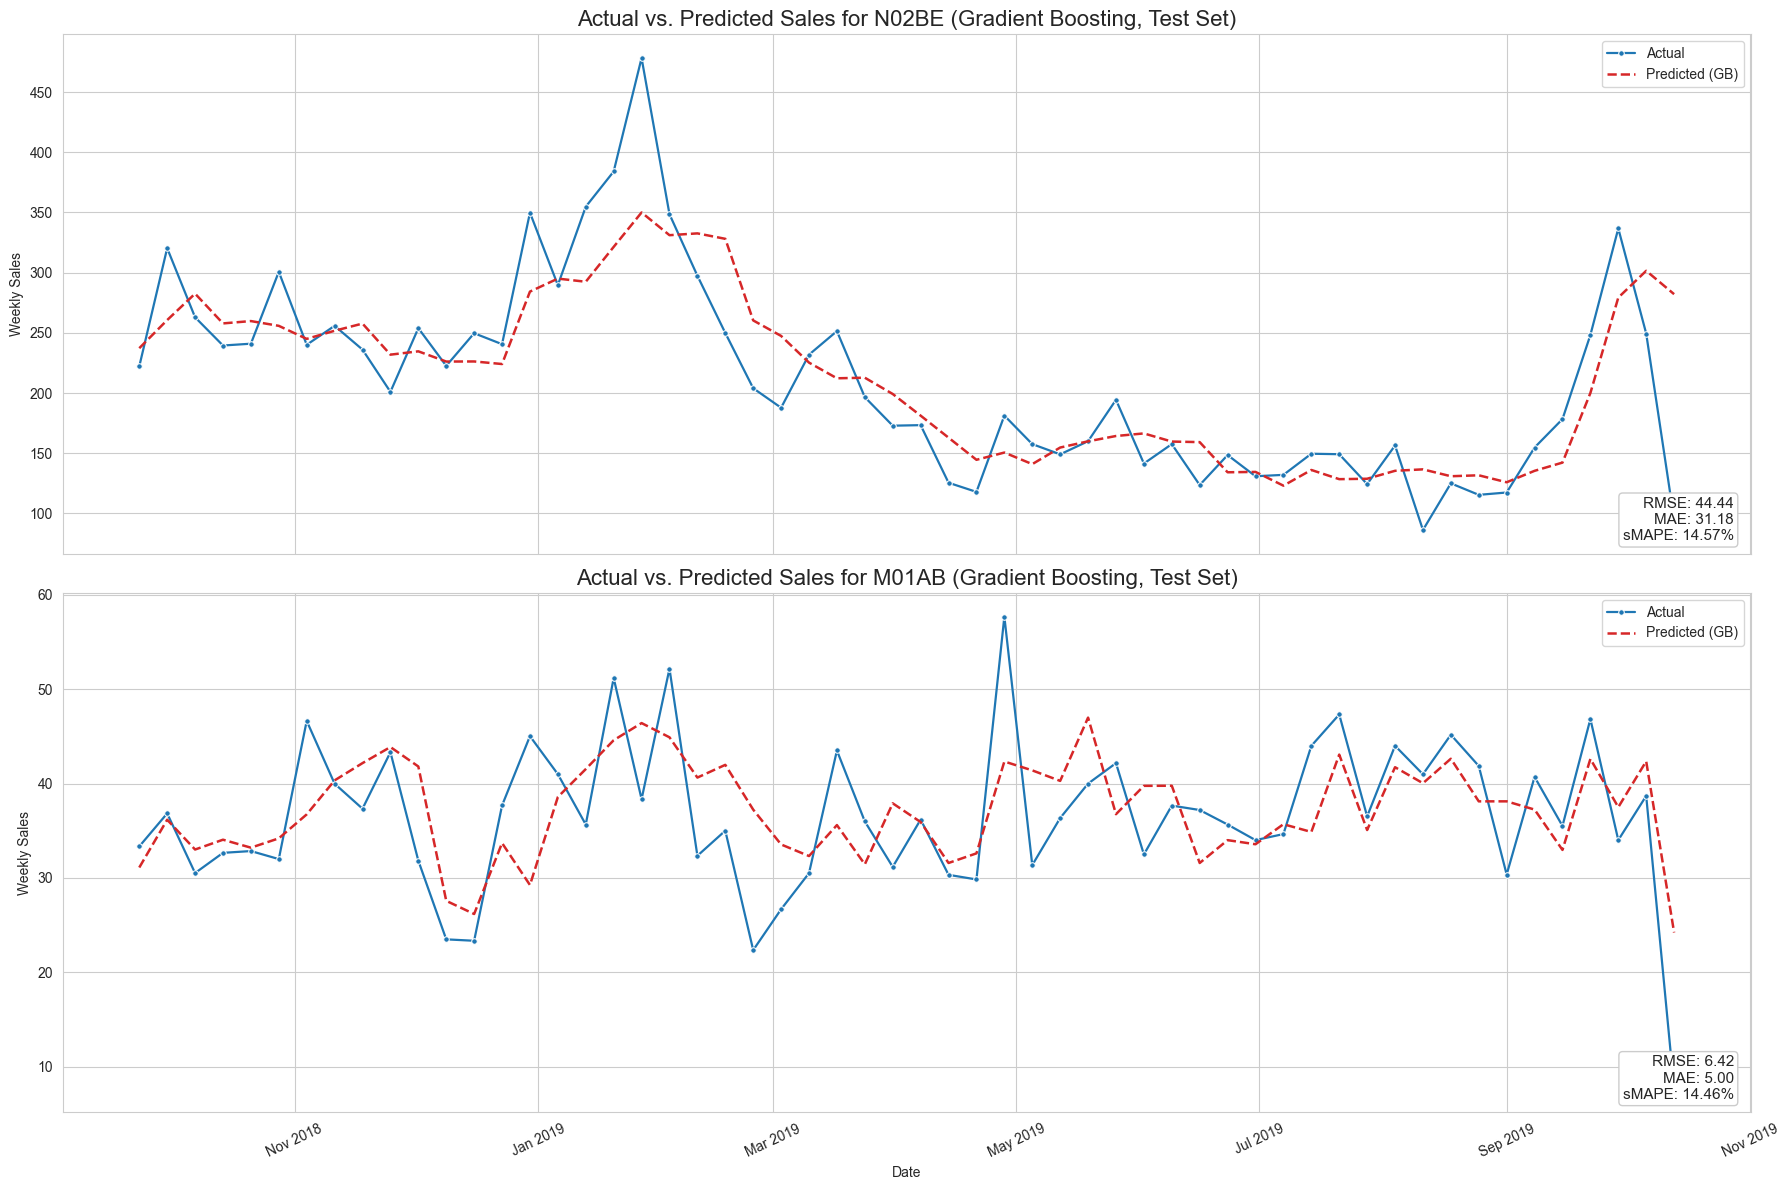

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pathlib import Path
import locale

# --- Locale setting for English month names ---
# (on Windows use 'English_United States', on macOS/Linux 'en_US.UTF-8')
try:
    locale.setlocale(locale.LC_TIME, "en_US.UTF-8")
except:
    locale.setlocale(locale.LC_TIME, "English_United States")

sns.set_style("whitegrid")

# --- 1) Detect the results directory ---
# Tries several common paths and selects the one containing gb_test_metrics.csv
candidates = [Path("./results/final"), Path("../results/final"), Path("results/final")]
RESULTS_DIR = next(
    (p for p in candidates if (p / "gb_test_metrics.csv").exists()), None
)
if RESULTS_DIR is None:
    raise FileNotFoundError(
        "gb_test_metrics.csv not found. Expected location: ../results/final/ \n"
        "Please verify where the result files were saved."
    )

print(f"Using RESULTS_DIR = {RESULTS_DIR.resolve()}")

# --- 2) Load model performance metrics ---
metrics_path = RESULTS_DIR / "gb_test_metrics.csv"
dfm = pd.read_csv(metrics_path)

# --- 3) Define the targets to visualize ---
targets = ["N02BE", "M01AB"]

# --- 4) Create figure with two subplots (one per target) ---
fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

for i, tgt in enumerate(targets):
    # Load prediction data for each target
    pred_path = RESULTS_DIR / f"gb_{tgt}_preds.csv"
    if not pred_path.exists():
        raise FileNotFoundError(f"Prediction file missing for {tgt}: {pred_path}")
    df_pred = pd.read_csv(pred_path, parse_dates=["date"]).sort_values("date")

    ax = axes[i]
    # Actual values
    sns.lineplot(
        data=df_pred,
        x="date",
        y="y_true",
        ax=ax,
        label="Actual",
        color="C0",
        marker="o",
        markersize=4,
        linewidth=1.6,
    )
    # Predicted values
    sns.lineplot(
        data=df_pred,
        x="date",
        y="y_pred",
        ax=ax,
        label="Predicted (GB)",
        color="C3",
        linestyle="--",
        linewidth=1.8,
    )

    # Chart title and labels
    ax.set_title(
        f"Actual vs. Predicted Sales for {tgt} (Gradient Boosting, Test Set)",
        fontsize=16,
    )
    ax.set_ylabel("Weekly Sales")
    ax.legend()

    # Format x-axis: show ticks every 2 months with English month names
    loc = mdates.MonthLocator(interval=2)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=25)

    # --- Add small metric box (RMSE, MAE, sMAPE) ---
    row = dfm[dfm["Target"] == tgt].iloc[0]
    txt = f"RMSE: {row['Test_RMSE']:.2f}\nMAE: {row['Test_MAE']:.2f}\nsMAPE: {row['Test_sMAPE(%)']:.2f}%"
    ax.text(
        0.99,
        0.02,
        txt,
        transform=ax.transAxes,
        ha="right",
        va="bottom",
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#ccc"),
    )

# Final axis label and layout adjustments
axes[-1].set_xlabel("Date")
fig.tight_layout()

# --- 5) Save the output plot ---
out_path = RESULTS_DIR / "plots_actual_vs_pred_gb_en.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight")
print(f"✅ Saved figure → {out_path}")

plt.show()

### Interpretation — Gradient Boosting Model Performance

The Gradient Boosting models demonstrate strong predictive capability across both therapeutic classes (N02BE and M01AB).  
In both plots, the predicted sales (dashed red lines) closely follow the actual weekly sales trends (solid blue lines),  
capturing the overall seasonal dynamics and local fluctuations of the series.

For **N02BE**, the model effectively tracks major peaks and troughs but slightly underestimates extreme highs,  
which may correspond to temporary promotional or stock-related effects not represented in the input features.  
Despite these localized deviations, the alignment between predicted and actual values indicates that the model  
generalizes well across the test period.

For **M01AB**, the model maintains high temporal stability and no systematic bias.  
Predictions remain close to the actual values throughout the test window, demonstrating good fit for a  
relatively low-variance product class.

Overall, the achieved error metrics (RMSE ≈ 44.4 / 6.4 and sMAPE ≈ 14.6%) confirm that the Gradient Boosting approach  
offers a well-balanced trade-off between accuracy and generalization.  
These results justify its selection as the **final model** for downstream forecasting and business reporting tasks.
